# Narrative analytics and experimentation

For this Unit 1 Capstone, I am interested in investigating the gun violence in the US. This was prompted by yet another shooting in Santa Fe High School, Texas, where 10 people were fatally shot and 13 injured. It was reported that while we are only 20 weeks into 2018, there has already been 22 school shootings, and the Santa Fe High School shooting was the third one in only eight days. Along with the Stoneman Douglas High School shooting in Parkland, Florida just about three months ago, the gun talk has become something that we cannot ignore, and there has been more and more heated debates on increasing the reinforcement of background checks and stricter gun laws.

## The datasets
To investigate this problem, I tapped into the gun violence data posted on Kaggle that was downloaded from [gunviolencearchive.org](http://www.gunviolencearchive.org/), an organization formed in 2013 to provide free online public access to accurate information about gun-related violence in the United States.

In addition, I also downloaded the firearm law provisions data of each state from the [State Firearm Law Database](https://www.statefirearmlaws.org/index.html) from Boston University School of Public Health.

## Visualization of the problem

Let's begin by taking a look at the data.

First, how has the gun violence prevalence changed over recent years?

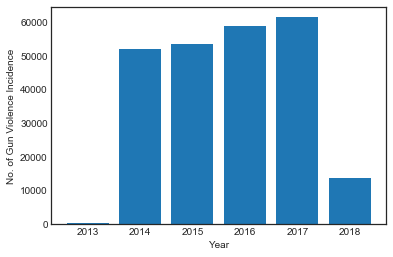

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Load data
df = pd.read_csv('gun-violence-data.csv')

#Organize data by year
df['year'] = pd.to_datetime(df['date']).dt.to_period('Y')

#Create a dataframe to visualize gun violence incidents by year
count_by_year = pd.DataFrame()
count_by_year['year'] = df['year'].value_counts().keys().tolist()
count_by_year['count'] = df['year'].value_counts().tolist()
count_by_year = count_by_year.sort_values('year')

sns.set_style('white')
label = count_by_year['year']
index = np.arange(len(label))
plt.bar(index, count_by_year['count'])
plt.xticks(index, label)
plt.xlabel('Year')
plt.ylabel('No. of Gun Violence Incidence')
plt.show()

From this graph, wee can see that 2013 and 2018 is sort of abnormal. But that's ok, because the organization that collects the gun violence data only started in 2013, and thus doesn't have the complete data of that year. And 2018 has only started.

But from the data between 2014-2017, we can see that there is a steady increase of gun violence incidents over these years.

We can also take a look to see which state has the most gun violence incidence.

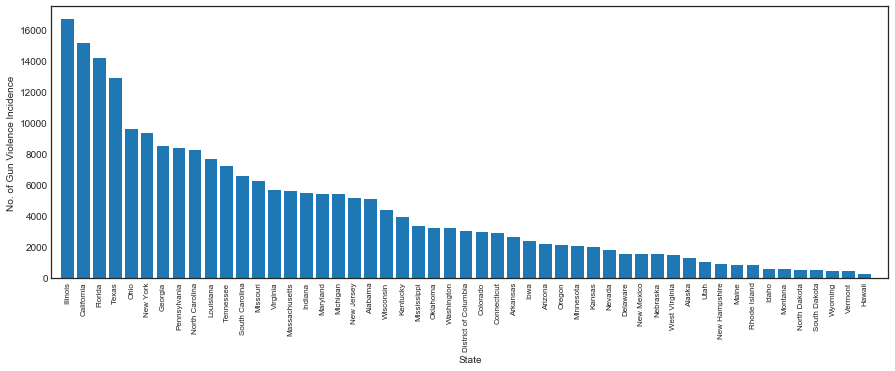

In [2]:
#Selecting data only between 2014-2017
df['year'] = df['year'].astype(str).astype(int)
df2 = df.loc[lambda df: df['year'].isin([2014, 2015, 2016, 2017]), :]

#Create a dataframe that organize by states.
count_by_state = pd.DataFrame()
count_by_state['state'] = df2.groupby(['state']).size().keys().tolist()
count_by_state['count'] = df2.groupby(['state']).size().tolist()
count_by_state['avg_killed'] = df2.groupby(['state'])['n_killed'].mean().tolist()
count_by_state['avg_injured'] = df2.groupby(['state'])['n_injured'].mean().tolist()
count_by_state = count_by_state.sort_values(['count'], ascending=False)

#Plot out number of gun violence in each state.
sns.set_style('white')
plt.figure(figsize=(15, 5))
label = count_by_state['state']
index = np.arange(len(label))
plt.bar(index, count_by_state['count'], width=0.8)
plt.xticks(index, label, fontsize=8, rotation=90)
plt.xlabel('State')
plt.ylabel('No. of Gun Violence Incidence')
plt.gca().set_xlim(left=-1, right=len(index)+0.5)
plt.show()


If needed, we can also plot out the average of number killed or injured in gun violence by each state too.

But the million dollar question is: how can we prevent the increase of gun violence? Many people would suggest stricter gun laws. However, whether stricter gun laws can truly reduce gun violence, especially in a country where the civilians already own massive amount of firearms, is unknown.

Before we formulate our hypothesis, we can take a look to see whether on a national scale, the strictness of gun laws affects the incidence of gun violence and the fatality of these incidences.

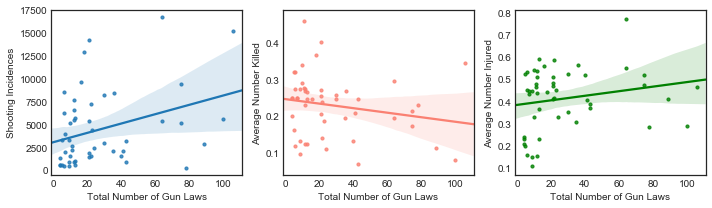

In [3]:
gunlaw2017 = pd.read_csv('state_gun_law2017.csv')
total_gunlaw = gunlaw2017[['state', 'lawtotal']]
merge = pd.merge(left=count_by_state,right=total_gunlaw, left_on='state', right_on='state')

census = pd.read_excel('nst-est2017-01.xlsx')
census.columns = census.iloc[2]
census.columns = census.columns.fillna('state')
census = census.iloc[8:59]
census['state'] = census.state.str.replace('.' , '')
census = census[['state', 2017.0]]
census.columns = ['state', 'population']
merge = pd.merge(left=merge,right=census, left_on='state', right_on='state')

sns.set_style('white')
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
sns.regplot(x='lawtotal', y='count', data=merge,
            scatter_kws={'s':10})
plt.xlabel('Total Number of Gun Laws')
plt.ylabel('Shooting Incidences')

plt.subplot(132)
sns.regplot(x='lawtotal', y='avg_killed', data=merge,
            scatter_kws={'s':10}, color='salmon')
plt.xlabel('Total Number of Gun Laws')
plt.ylabel('Average Number Killed')

plt.subplot(133)
sns.regplot(x='lawtotal', y='avg_injured', data=merge,
            scatter_kws={'s':10}, color='g')
plt.xlabel('Total Number of Gun Laws')
plt.ylabel('Average Number Injured')
plt.tight_layout()
plt.show()


From what we can see here, quite contrary to general liberal views, the states with more firearm provisions actually seem to suffer from more shooting incidences. What's worth noticing is that correlation doesn't equal to causal relationship. In fact, it could be the other way around. Because these states see higher prevalence of gun violence, it results in the legislation of more firearm provisions.

On the other hand, we can see in the states with stricter gun laws, the average number of people killed in each shooting seems to be less.

However, these are only correlational observations, and we need experiment to investigate the causal relationship between gun law and gun violence. Based on the information at hand, we can propose the following experiment plan:

__Hypothesis:__ enforcing new gun law would increase gun violence incidence.

For this experiment, we can choose a few pairs of states that have very similar features regarding gun violence, and divide each pair into two groups. Then enforce a certain gun law (e.g. no carrying, open or conceal, in public space) in one group, and not enforcing it in the other group. By observation of the data at hand, I picked out the following states.

(The population data was pulled from [US census data](https://www.census.gov/data.html).)

In [4]:
merge.loc[[2, 3, 7, 8, 36, 37, 40, 41]]

,state,count,avg_killed,avg_injured,lawtotal,population
2,Florida,14197,0.254983,0.468902,21,20984400.0
3,Texas,12890,0.365555,0.441505,18,28304596.0
7,Pennsylvania,8413,0.266968,0.565791,36,12805537.0
8,North Carolina,8263,0.255597,0.524991,30,10273419.0
36,Nebraska,1541,0.138871,0.414666,22,1920076.0
37,West Virginia,1493,0.206296,0.407904,21,1815857.0
40,New Hampshire,917,0.094875,0.146129,9,1342795.0
41,Maine,849,0.122497,0.151943,12,1335907.0


From this table, we can see that Florida and Texas are quite similar in all the relevant features, and so do Pennsylvania vs North Carolina, Nebraska vs West Virginia, and New Hampshire vs Maine.

Therefore, we have our two groups:
__Group 1__: Florida, North Carolina, Nebraska, Maine, where the new law will be reinforced
__Group 2__: Texas, Pennsylvania, West Virginia, New Hampshire, where the new law will not be reinforced.

Then we monitor these states for gun violence.

__Duration__: one year.

__Key outcome__: percent change of gun violence incidence and number of people killed in an incidence

__Secondary outcomes__: number of people injured in an incidence, gun purchase, gun type used in each incidence, population etc.

__Evaluation__: T-test on the percent change of gun violence incidence between the two groups, as well as t-test on the number of people killed in each incidence. If it's significantly different, then we can argue the enforcement of the new gun law has an effect on the gun violence incidence and the fatality of these incidences.